<a href="https://colab.research.google.com/github/balu337/TicketClassification/blob/main/SoumAutomatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 19.8 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=fa0d200e7e2acfd858101d6a76f0a0c5b17afc9bf93618a81ba2ee7ca55410c3
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import swifter

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Opening JSON file
# f = open('/content/drive/MyDrive/inportant/Learning/ML/NLP/SemanticProcessing/semantic_processing-main/Topic Modelling/Assignment/complaints-2021-05-14_08_16.json')
f = open('/content/drive/MyDrive/Soumyadeep/Learning/ML/TopicModeling/Assignment/complaints-2021-05-14_08_16.json')

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [ ]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign new column names
df.columns = ['index', 'type', 'id','score','tags','zip_code','complaint_id','issue','date_received','state','consumer_disputed','product','company_response','company','submitted_via','date_sent_to_company','company_public_response','sub_product','timely','complaint_details','sub_issue','consumer_consent']

In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint_details'] = df['complaint_details'].apply(lambda x: x.strip()).replace('', np.nan)

In [ ]:
#Remove all rows where complaints column is nan
df= df[df['complaint_details'].notnull()]

In [ ]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
pd.set_option('display.max_colwidth', None) #Print the whole data

In [ ]:
from gensim.utils import simple_preprocess
import gensim

In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_sentences(sent):
  sent=sent.lower()  #convert to lower case
  sent=re.sub(r'\[[\w]*\]','',sent) #Remove text in square brackets
  sent=re.sub(r'x*','',sent) #Remove words with xx
  sent=re.sub(r'\d+','',sent) #Remove words with numbers
  return sent

In [ ]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)# functions for removing stopwords and lemmatization
def remove_stopwords_punctuations(doc):
    return " ".join([word for word in simple_preprocess(str(doc)) if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Write your function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    doc = nlp(texts)
    texts_out= ([token.lemma_ for token in doc])
    return " ".join(texts_out)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [ ]:
df['complaint_details_mod'] = df['complaint_details'].apply(lambda x: clean_sentences(x))

In [ ]:
df['complaint_details_mod'] = df['complaint_details_mod'].apply(lambda x: remove_stopwords_punctuations(x))

In [ ]:
df['complaint_details_lemmatized'] = df['complaint_details_mod'].apply(lambda x: lemmatization(x))

In [ ]:
df_clean = df[['complaint_details', 'complaint_details_lemmatized']]

In [ ]:
df_clean.head()

,complaint_details,complaint_details_lemmatized
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report however fraudulent application submit identity without consent fraudulently obtain service etend credit without verify identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",try book ticket come across offer apply towards ticket apply reward card put information offer within less minute notify via screen decision could make immediately contact refer chase bank immediately contact chase bank within minute get notification screen tell chase representative speak application deny could state ask information offer eplaine even approve credit offer get apply first account statement could use purchase ticket eplicitly tell glad get deny absolutely long interested account ask application withdraw representative oblige happen later min put application notwithstanding eplicit request proceed application contrary tell chase representative chase fact go ahead open credit account name report credit report chase refuse corr

In [ ]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
    doc = nlp(text)
    texts_out = ([token.lemma_ for token in doc if token.tag_ == 'NN'])
    return " ".join(texts_out)


df_clean["complaint_POS_removed"] =  df_clean['complaint_details_lemmatized'].swifter.apply(lambda x: pos_tag(x))#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

<ipython-input-22-44f86efa276b>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.head()

,complaint_details,complaint_details_lemmatized,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report however fraudulent application submit identity without consent fraudulently obtain service etend credit without verify identity applicant,chase card report application submit identity consent service etend credit verify identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.",try book ticket come across offer apply towards ticket apply reward card put information offer within less minute notify via screen decision could make immediately contact refer chase bank immediately contact chase bank within minute get notification screen tell chase representative speak application deny could state ask information offer e

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_details_length'] = df_clean['complaint_details'].str.len()
df_clean['complaint_details_lemmatized_length'] = df_clean['complaint_details_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_details_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaint_details_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

<ipython-input-24-bb51d259951c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-bb51d259951c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-bb51d259951c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



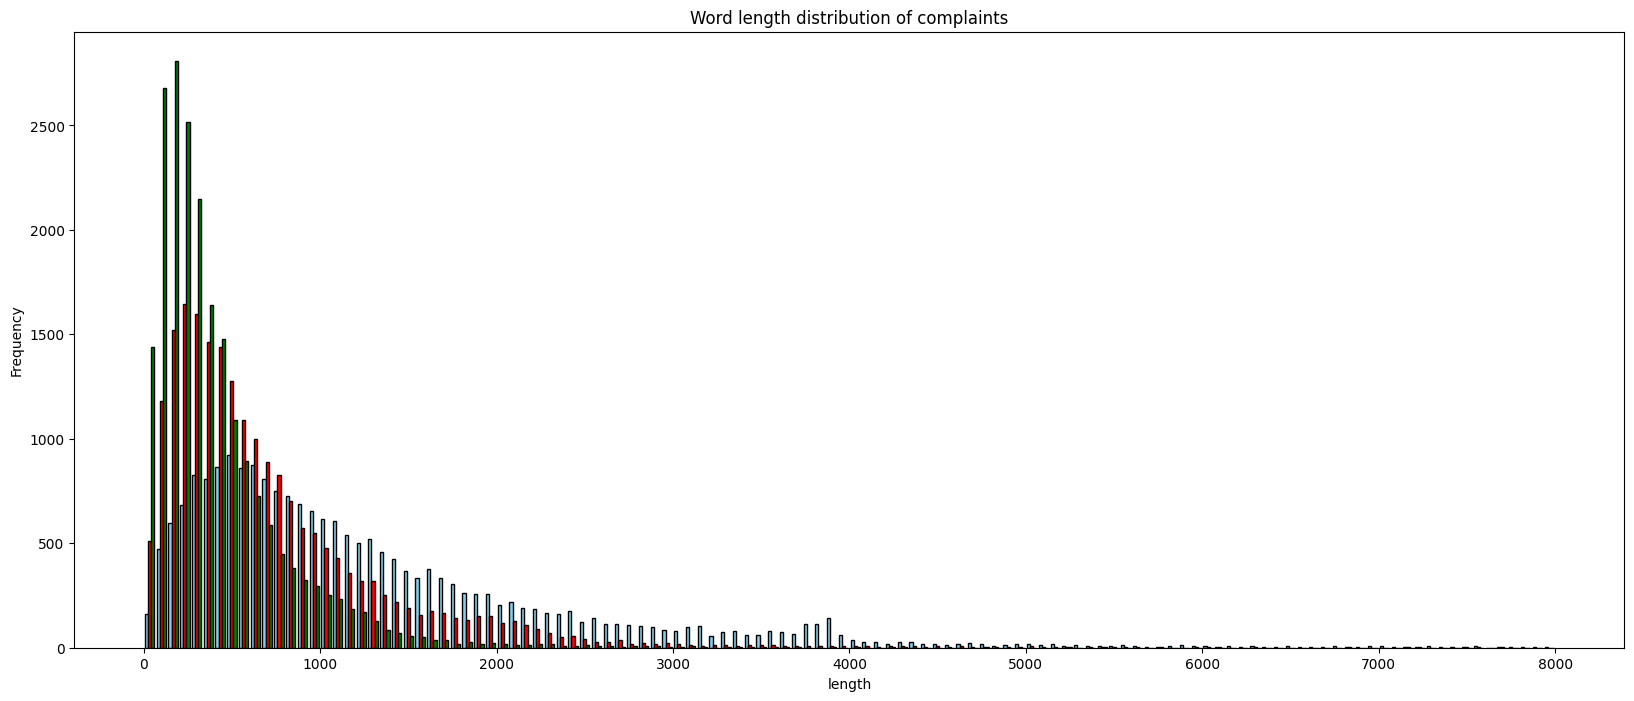

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.hist(df_clean[['complaint_details_length','complaint_details_lemmatized_length','complaint_POS_removed_length']], bins=120, color=['skyblue', 'red', 'green'], edgecolor='black', range = [0,8000])

# Adding labels and title
plt.xlabel('length')
plt.ylabel('Frequency')
plt.title('Word length distribution of complaints')
# Display the plot
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
from wordcloud import WordCloud   # for the wordcloud
def generateWordCloud(noOfWords):
  return WordCloud(width = 2000, height = 1334, random_state=1, background_color='black', colormap='Pastel1', max_words = noOfWords, collocations=False, normalize_plurals=False).generate(' '.join(df_clean['complaint_POS_removed']))

In [ ]:
import matplotlib.pyplot as plt   # for wordclouds & charts
from matplotlib.pyplot import figure

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(25, 17), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close()



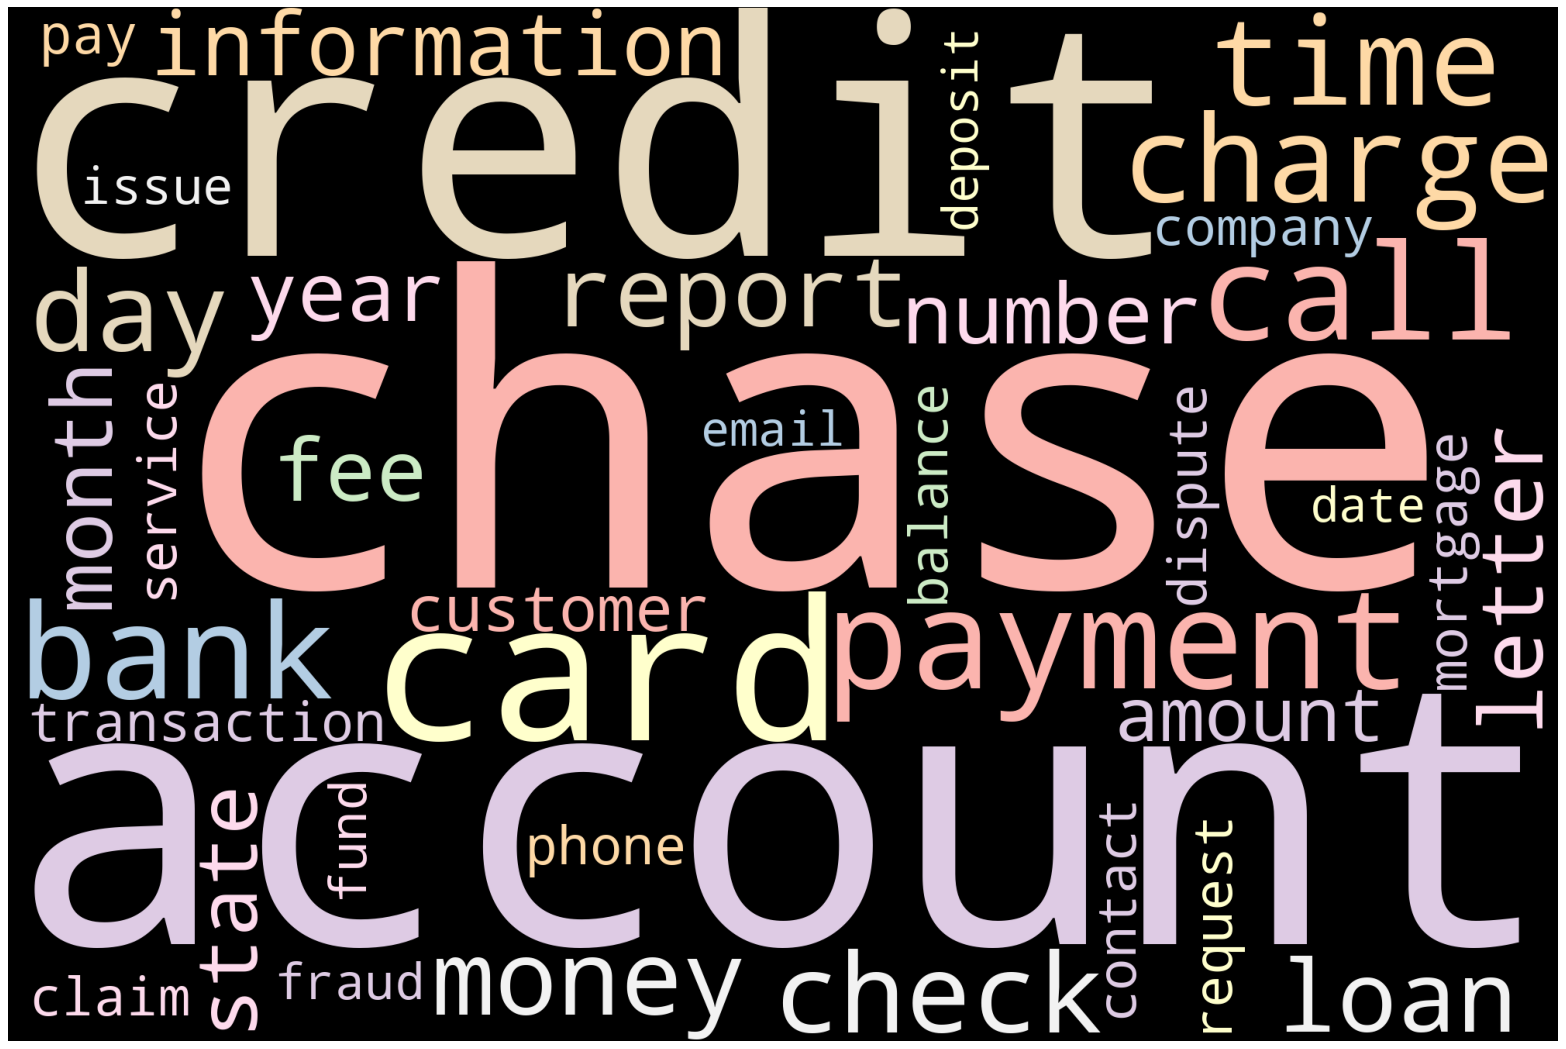

In [ ]:
#Plot
wordCloud = generateWordCloud(40)
plot_cloud(wordCloud)

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-29-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
complaintString ='  '.join(df_clean['Complaint_clean'])

In [ ]:
from nltk.util import ngrams
import collections

def getNgrams(ngram):
  grams = ngrams(complaintString.split(), ngram)
  return collections.Counter(grams)


In [ ]:
#Print the top 10 words in the unigram frequency
print(getNgrams(1).most_common(10))

[(('chase',), 59867), (('account',), 44008), (('credit',), 33929), (('card',), 30260), (('payment',), 21361), (('call',), 19549), (('bank',), 19064), (('time',), 16040), (('charge',), 15634), (('day',), 13277)]


In [ ]:
#Print the top 10 words in the bigram frequency
print(getNgrams(2).most_common(10))

[(('credit', 'card'), 12876), (('call', 'chase'), 3979), (('credit', 'report'), 3973), (('chase', 'credit'), 3388), (('check', 'account'), 3135), (('customer', 'service'), 3009), (('chase', 'bank'), 2756), (('account', 'chase'), 2602), (('chase', 'account'), 2148), (('debit', 'card'), 2018)]


In [ ]:
#Print the top 10 words in the trigram frequency
print(getNgrams(3).most_common(10))

[(('chase', 'credit', 'card'), 2441), (('credit', 'card', 'account'), 1069), (('credit', 'card', 'company'), 972), (('credit', 'card', 'chase'), 760), (('chase', 'customer', 'service'), 593), (('inquiry', 'credit', 'report'), 505), (('call', 'customer', 'service'), 452), (('charge', 'credit', 'card'), 420), (('credit', 'card', 'credit'), 419), (('credit', 'reporting', 'agency'), 381)]


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')#Already implemented previously

<ipython-input-35-42275e62a591>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#All masked texts has been removed
df_clean.head()

,complaint_details,complaint_details_lemmatized,complaint_POS_removed,complaint_details_length,complaint_details_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,486,280,167,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent,355,181,115,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report however fraudulent application submit identity without consent fraudulently obtain service etend credit without verify identity applicant,chase card report application submit identity consent service etend credit verify identity applicant,224,155,100,chase card report application submit identity consent service etend credit verify identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credi

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer
vect = TfidfVectorizer(stop_words='english')



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean['Complaint_clean'])

pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

,aa,aaa,aaccount,aacount,aarp,abandon,abandonde,abandonment,abate,abatement,...,zeal,zeroed,zilch,zinging,zip,zipcode,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [ ]:
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [ ]:
#Print the Top15 words for each of the topics
# Top 10 words per topic

words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    # print(ix)
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,deposit,chase,fund,branch,day,transfer,transaction,number,business,claim,customer
Topic 2,card,charge,chase,credit,dispute,purchase,fee,transaction,service,merchant,fraud,balance,use,time,company
Topic 3,loan,mortgage,chase,modification,home,property,year,letter,document,rate,time,request,foreclosure,sale,refinance
Topic 4,credit,report,inquiry,card,account,score,debt,company,reporting,information,identity,remove,application,chase,theft
Topic 5,payment,balance,month,pay,fee,statement,auto,chase,time,day,date,credit,account,year,mortgage


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W.argmax(axis=1)


array([2, 1, 3, ..., 1, 4, 4])

In [ ]:
W.argmax(axis=1).shape

(21072,)

In [ ]:
df_clean.shape

(21072, 7)

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1)#write your code to assign topics to each rows.

<ipython-input-46-191ea77940c0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.head()

,complaint_details,complaint_details_lemmatized,complaint_POS_removed,complaint_details_length,complaint_details_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,486,280,167,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,2
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent,355,181,115,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report however fraudulent application submit identity without consent fraudulently obtain service etend credit without verify identity applicant,chase card report application submit identity consent service etend credit verify identity applicant,224,155,100,chase card report application submit identity consent service etend credit verify identity applicant,3
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

,complaint_details,complaint_details_lemmatized,complaint_POS_removed,complaint_details_length,complaint_details_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
17,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. This situation is truly affecting my livelihood and they dont seem to want to deal with Me professionally. Thank you",notice morgan chase restrict account debit card tuesday thursday go branch advise customer service representative account would actually close go branch see remove fund currently well direct deposit place employment would return bank associate customer service representative assure fund would post may take additional business day saturday attempt go inside branch yet retrieve fund actually post friday upon look account realize fund reverse long present current statement I ve call tell may take two business day state tuesday would date fund would available withdraw bank teller chase inform mail check three business day recover fund owe left account currently unfortunately put additional financial bind two fee late rent late car payment etc short give write notice thing actually occur peace mind fact chase handle situation grossly even bank teller inform account look suspicious give suspicious look although know chase reserve right close account time believe protocol past give notice form write document shore give write notice thing actually occur peace mind fact chase handle situation grossly even bank teller inform account look suspicious give suspicious look although know chase reserve right close account time believe protocol past give notice form write document situation truly affect livelihood do not seem want deal professionally thank,account debit card branch customer service representative account branch remove fund deposit place employment bank customer service representative fund business day attempt 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics


Topic_names = { 0: 'Bank Account services',
1: 'Credit card or prepaid card',
2 : 'Mortgage/Loan',
3 : 'Theft/Dispute Reporting',
4: 'Others'  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-49-6ccc92cc6034>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.shape

(21072, 8)

In [ ]:
df_clean

,complaint_details,complaint_details_lemmatized,complaint_POS_removed,complaint_details_length,complaint_details_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,486,280,167,morning name appreciate bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,Mortgage/Loan
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent,355,181,115,card agent upgrade anniversary date agent information order account change anniversary date consent recording agent,Credit card or prepaid card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card report however fraudulent application submit identity without consent fraudulently obtain service etend credit without verify identity applicant,chase card report application submit identity consent service etend credit verify identity applicant,224,155,100,chase card report application submit identity consent service etend credit verify identity applicant,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit 

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_details','Topic']]

In [ ]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count
count_vect=CountVectorizer()
X_train_counts=count_vect.fit_transform(training_data['complaint_details'])
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split, RandomizedSearchCV, KFold

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay




In [ ]:
# Prepare the training and test data
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40)

In [ ]:
#Model evaluation
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print('=====================Results for ', type , '==========================')
    print('Accuracy: ', accuracy_score(y_test,y_pred))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted').round(2))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted').round(2))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted').round(2))
    print('ROC AUC Score: ', roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    # disp.plot()

In [ ]:
#Execute the model
#**Imp** I was not able to run grid search as it was getting timed out.
def run_model(model,param_grid, train_X,train_y ):
    folds = KFold(n_splits = 5, shuffle = True, random_state = 40)
    grid=GridSearchCV(model,param_grid={},cv=folds,scoring='roc_auc',verbose=1,n_jobs=-1)
    grid.fit(train_X,train_y)
    return grid.best_estimator_

In [ ]:
train_X.shape

(16857, 29725)

In [ ]:
test_y.shape

(4215,)

#####Logistic Regression model

In [ ]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 400],
}
model=run_model(LogisticRegression(),params, train_X,train_y)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [nan]



=====================Results for  Training ==========================
Accuracy:  0.9692116034881652
Precision:  0.97
Recall:  0.97
F1 Score:  0.97
ROC AUC Score:  1.0
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.96      0.99      0.97      4387
Credit card or prepaid card       0.96      0.98      0.97      5074
              Mortgage/Loan       0.97      0.97      0.97      3102
                     Others       0.99      0.93      0.96      1915
    Theft/Dispute Reporting       0.98      0.94      0.96      2379

                   accuracy                           0.97     16857
                  macro avg       0.97      0.96      0.97     16857
               weighted avg       0.97      0.97      0.97     16857

=====================Results for  Test ==========================
Accuracy:  0.9274021352313168
Precision:  0.93
Recall:  0.93
F1 Score:  0.93
ROC AUC Score:  0.99
Classification Report

#####Random forest classifier

In [ ]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [10, 50, 100, 150, 200, 500],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [4, 6, 8, 10, 12, 15],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_leaf_nodesint' : [None, 10,12,16.18,20]
}
model=run_model(RandomForestClassifier(),params,train_X,train_y)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [nan]



=====================Results for  Training ==========================
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       1.00      1.00      1.00      4387
Credit card or prepaid card       1.00      1.00      1.00      5074
              Mortgage/Loan       1.00      1.00      1.00      3102
                     Others       1.00      1.00      1.00      1915
    Theft/Dispute Reporting       1.00      1.00      1.00      2379

                   accuracy                           1.00     16857
                  macro avg       1.00      1.00      1.00     16857
               weighted avg       1.00      1.00      1.00     16857

=====================Results for  Test ==========================
Accuracy:  0.8059311981020166
Precision:  0.82
Recall:  0.81
F1 Score:  0.79
ROC AUC Score:  0.97
Classification Report:                 

#####Bernouli Naive Bayes algo

In [ ]:
#running and evaluating the Bernoili Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}
model=run_model(BernoulliNB(),params,train_X,train_y)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [nan]



=====================Results for  Training ==========================
Accuracy:  0.6895058432698582
Precision:  0.77
Recall:  0.69
F1 Score:  0.71
ROC AUC Score:  0.91
Classification Report:                               precision    recall  f1-score   support

      Bank Account services       0.84      0.75      0.79      4387
Credit card or prepaid card       0.87      0.68      0.76      5074
              Mortgage/Loan       0.86      0.64      0.73      3102
                     Others       0.75      0.49      0.60      1915
    Theft/Dispute Reporting       0.36      0.83      0.50      2379

                   accuracy                           0.69     16857
                  macro avg       0.74      0.68      0.68     16857
               weighted avg       0.77      0.69      0.71     16857

=====================Results for  Test ==========================
Accuracy:  0.6453143534994069
Precision:  0.73
Recall:  0.65
F1 Score:  0.66
ROC AUC Score:  0.88
Classification Repor

#####XGBoost algo

In [ ]:

Topic_name_reverse_map = { 'Bank Account services': 0,
'Credit card or prepaid card' :1,
'Mortgage/Loan': 2 ,
'Theft/Dispute Reporting': 3,
'Others': 4  }

In [ ]:
train_y_xgBoost = train_y.map(Topic_name_reverse_map)
test_y_xgBoost = test_y.map(Topic_name_reverse_map)

In [ ]:
#running and evaluating the XGBoost model
params = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}
model=run_model(XGBClassifier(),params, train_X,train_y_xgBoost)
eval_model(train_y_xgBoost,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y_xgBoost,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [nan]



=====================Results for  Training ==========================
Accuracy:  0.999466097170315
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4387
           1       1.00      1.00      1.00      5074
           2       1.00      1.00      1.00      3102
           3       1.00      1.00      1.00      2379
           4       1.00      1.00      1.00      1915

    accuracy                           1.00     16857
   macro avg       1.00      1.00      1.00     16857
weighted avg       1.00      1.00      1.00     16857

=====================Results for  Test ==========================
Accuracy:  0.9136417556346382
Precision:  0.91
Recall:  0.91
F1 Score:  0.91
ROC AUC Score:  0.99
Classification Report:                precision    recall  f1-score   support

           0       0.91      0.94      0.93      1089
           1       0.92    

####Detailed analysis of model performances


|-------------------|------------------------|Training data | -------------------------|--------------------|Testing data|----------------------------|
|--------------|-------------|-----|--|--|||

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC Score | Accuracy | Precision | Recall | F1 Score | ROC AUC Score |
| ------------------- | -------- | --------- | ------ | -------- | ------------- | -------- | --------- | ------ | -------- | ------------- |
| Logistic Regression | 0.97     | 0.97      | 0.97   | 0.97     | 1             | 0.93     | 0.93      | 0.93   | 0.93     | 0.99          |
| Random Forest       | 1        | 1         | 1      | 1        | 1             | 0.79     | 0.76      | 0.86   | 0.92     | 0.87          |
| Bernouli NB         | 0.69     | 0.77      | 0.69   | 0.71     | 0.91          | 0.65     | 0.73      | 0.65   | 0.66     | 0.88          |
| XGBoost             |     1     |         1  |      1  |      1    |         1      |      0.91    |     0.92      |    0.91    |     0.90     |0.92

According to the information it can be understandable that the Logistic regression is doing good whereas Random Forest is overfitting.